In [1]:

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [1]:


import os
import sys
module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
import pandas as pd
import pickle
import json
from itertools import repeat
import multiprocess
from pprint import pprint
import numpy as np
import pvlib
import proplot as pplt
import ipv_workbench as ipv
from ipv_workbench.utilities import utils, circuits, time_utils
from ipv_workbench.devices import devices
from ipv_workbench.simulator import simulations as ipv_sim
from ipv_workbench.simulator import simulations_mp as ipv_sim_mp
from ipv_workbench.simulator import calculations as ipv_calc
from ipv_workbench.visualize import plots as ipv_plots
from ipv_workbench.translators import panelizer
from ipv_workbench.sample import dummies
from tqdm import tqdm
import functools, operator, collections
import multiprocess as mp
import time

In [2]:

## Create Ccll
file_p = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/devices/default_devices/cell_parameters_default_monocrystalline.txt"
my_cell = devices.Cell(file_p)
iv_library_name = "/Users/jmccarty/Data/220723_iv_library/library/test_cell/test_gzip.gz"
my_cell.assign_iv_library(iv_library_name)


In [3]:
## Build up dummy object
n_srfs = 2
n_series = 4
n_modules = 5

sample_dict = dummies.generate_sample_building_dict(n_srfs, n_series, n_modules)
po = panelizer.PanelizedObject(sample_dict)
po.cell = my_cell

## Load weather data
tmy_file = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/sample/zurich_2007_2021.epw"
po.tmy_dataframe = utils.tmy_to_dataframe(tmy_file)

In [106]:
####### start simulation within loop #######
def simulate_system(po, surface, hoy):
    
    if po.topology == 'central_inverter':
        ipv_sim.simulation_central_inverter(
            po, surface, hoy)
    elif po.topology == 'string_inverter':
        ipv_sim.simulation_string_inverter(
            po, surface, hoy)
    elif po.topology == 'micro_inverter':
        ipv_sim.simulation_micro_inverter(
            po, surface, hoy)

####### write results for string inverter #######
def write_string_inverter(po, surface, hoy):
    
    # TODO the initial write can be done during the simulation
    
    # get the strings
    strings = po.get_strings(surface)

    # break out the results dict into individual lists
    # i_list = results_dict[hoy][0]
    # v_list = results_dict[hoy][1]
    # g_list = results_dict[hoy][2]
    i_list = [po.get_dict_instance([surface, string])['CURVES'][po.topology]['Istr'][hoy] for string in po.get_strings(surface)]
    v_list = [po.get_dict_instance([surface, string])['CURVES'][po.topology]['Vstr'][hoy] for string in po.get_strings(surface)]
    g_list = [po.get_dict_instance([surface, string])['YIELD'][po.topology]['irrad'][hoy] for string in po.get_strings(surface)]

    # this loops through each "string" in the results
    for n in range(0, len(i_list)):

        # get the result keys from the string level
        string_result_keys = list(po.get_dict_instance([surface, strings[n]])[
                                  'YIELD'][po.topology].keys())

        # calculate mpp and related ->  [Imp, Vmp, Pmp, Isc, Voc, FF]
        # store in a temp directory
        simulation_results_string = ipv_sim.calcMPP_IscVocFF(np.array(i_list[n]),
                                                             np.array(v_list[n]))
        temp_results_dict = utils.generate_empty_results_dict(
            target='STRING')
        temp_results_dict.update(simulation_results_string)
        temp_results_dict.update({'irrad': g_list[n]})

        # store everything in a dict
        if g_list[n] == 0:
            temp_results_dict.update({'eff': 0})
        else:
            efficiency = temp_results_dict['pmp'] / temp_results_dict['irrad']
            temp_results_dict.update({'eff': efficiency})

        # iterate over the result keys and write then to the panelizer object
        for key in string_result_keys:
            # write to the panelizer object at the string level
            po.get_dict_instance([surface, strings[n]])[
                'YIELD'][po.topology][key].update({hoy: np.round(temp_results_dict[key], 3)})

        # get the current at maximum power point to send to the module to calculate the power at MPP on the module
        operating_imp = np.round(temp_results_dict['imp'], 3)

        # loop through all modules in the string to calculate the power of the module using imp
        # then write this and then calculat ethe efficiency using the svaed irrad
        for module in po.get_modules(surface, strings[n]):

            Imod_hoy = po.get_dict_instance(
                [surface, strings[n], module])['CURVES'][po.topology]['Imod'][hoy]
            Vmod_hoy = po.get_dict_instance(
                [surface, strings[n], module])['CURVES'][po.topology]['Vmod'][hoy]

            # interp the relationship between I and V for the hour o the module using the oeprating I
            operating_vmp = np.round(np.interp(operating_imp, np.flipud(Imod_hoy),
                                               np.flipud(Vmod_hoy)), 5)
            module_input_energy = po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['irrad'][hoy]
            module_mpp_power = np.round(operating_vmp * operating_imp, 3)
            if module_input_energy == 0:
                module_eff = 0
            else:
                module_eff = np.round(
                    module_mpp_power / module_input_energy, 3)

            # write these results to the module dict
            po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['imp'].update({hoy: operating_imp})
            po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['vmp'].update({hoy: operating_vmp})
            po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['pmp'].update({hoy: module_mpp_power})
            po.get_dict_instance([surface, strings[n], module])[
                'YIELD'][po.topology]['eff'].update({hoy: module_eff})

####### write string results #######
def write_up_string_results(po, surface, string):
    string_dict = po.get_dict_instance([surface, string])['YIELD'][po.topology]

    sub_dict = po.get_dict_instance([surface, string])['MODULES']

    for key in string_dict.keys():
        key_result = utils.gather_sublevel_results(po,
                                    sub_dict,
                                    po.get_modules(surface,string),
                                    key)
        string_dict[key].update(key_result)
        
    # recalculate efficiency
    for hoy_n, hoy in enumerate(range(0, 24)):
        string_power = string_dict['pmp'][hoy]
        string_irrad = string_dict['irrad'][hoy]
        if string_irrad == 0:
            string_efficiency = 0
        else:
            string_efficiency = np.round(string_power / string_irrad, 3)
        string_dict['eff'][hoy] = string_efficiency


####### write surface results #######
def write_up_surface_results(po, surface):
    if po.topology=='central_inverter': 
        pass
    else:
        # set the surface dict to the results section
        surface_dict = po.get_dict_instance([surface])['YIELD'][po.topology]

        # get the dict at the surface level to write into
        surface_strings_dict = po.get_dict_instance([surface])['STRINGS']

        for key in surface_dict.keys():
            key_result = utils.gather_sublevel_results(po,
                                                    surface_strings_dict,
                                                    po.get_strings(surface),
                                                    key)
            surface_dict[key].update(key_result)

        # recalculate efficiency
        for hoy_n, hoy in enumerate(range(0, 24)):
            surface_power = surface_dict['pmp'][hoy]
            surface_irrad = surface_dict['irrad'][hoy]
            if surface_irrad == 0:
                surface_efficiency = 0
            else:
                surface_efficiency = np.round(surface_power / surface_irrad, 3)
            surface_dict['eff'][hoy] = surface_efficiency

####### write object results #######
def write_up_object_results(po):
    object_dict = po.panelizer_dict[po.object_type]['YIELD'][po.topology]

    for key in object_dict.keys():
        key_result = utils.gather_sublevel_results(po,
                                                   po.panelizer_dict[po.object_type]['SURFACES'],
                                                   po.get_surfaces(),
                                                   key)
        object_dict[key].update(key_result)

    # recalculate efficieny
    for hoy_n, hoy in enumerate(range(0, 24)):
        object_power = object_dict['pmp'][hoy]
        object_irrad = object_dict['irrad'][hoy]
        if object_irrad == 0:
            object_efficiency = 0
        else:
            object_efficiency = np.round(object_power / object_irrad, 3)
        object_dict['eff'][hoy] = object_efficiency


In [107]:
po.topology = 'micro_inverter'


for surface in po.get_surfaces():
    po.reset_results_dict(surface)
    for hoy in tqdm(range(0,24)):
        simulate_system(po, surface, hoy)
        
        write_first_level_results(po, surface, hoy) # topology dependent
    
    for string in po.get_strings(surface):
        if po.topology=='micro_inverter':
            write_up_string_results(po, surface, string)

    write_up_surface_results(po, surface)

write_up_object_results(po)
    

100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


In [14]:
def loop_module_simulation(panelizer_object, surface, string):

    modules_i = []
    modules_v = []
    modules_g = []

    for module in panelizer_object.get_modules(surface, string):
        print(module)
        mp_results = run_mp_simulation(panelizer_object, surface, string, module)
        
        Imod = {}
        Vmod = {}
        Gmod = {}

        for n in np.arange(0,po.ncpu):
            Imod.update(mp_results[n]['I'])
            Vmod.update(mp_results[n]['V'])
            Gmod.update(mp_results[n]['G'])
        
        modules_i.append(Imod)
        modules_v.append(Vmod)
        modules_g.append(Gmod)

        for hoy in panelizer_object.all_hoy:
            
            panelizer_object.get_dict_instance([surface, string, module])['CURVES'][panelizer_object.topology][
                'Imod'].update({hoy: np.round(Imod[hoy], 3)})
            panelizer_object.get_dict_instance([surface, string, module])['CURVES'][panelizer_object.topology][
                'Vmod'].update({hoy: np.round(Vmod[hoy], 3)})
            panelizer_object.get_dict_instance([surface, string, module])['YIELD'][panelizer_object.topology][
                'irrad'].update({hoy: np.round(Gmod[hoy], 1)})

    return modules_i, modules_v, modules_g

def run_mp_simulation(panelizer_object, surface, string, module):

    total_timesteps = len(panelizer_object.all_hoy)

    ncpu = panelizer_object.ncpu
    hoy_chunks = time_utils.create_timestep_chunks(total_timesteps, ncpu)

    pool = mp.Pool(ncpu)
    print("Pool Opened")
    time.sleep(1)
    args = zip([panelizer_object]*ncpu,
               [surface]*ncpu,
               [string]*ncpu,
               [module]*ncpu,
               hoy_chunks)

    result = pool.starmap(mp_simulation_wrapper, args)
    print("Result Gathered")
    time.sleep(1)
    pool.close()
    print("Pool closed")
    return result

def mp_simulation_wrapper(panelizer_object, surface, string, module, hoy_chunk):
    modules_i_dict = {}
    modules_v_dict = {}
    modules_g_dict = {}

    for hoy in hoy_chunk:
        Imod, Vmod, Gmod = simulation_module_yield(panelizer_object, surface, string, module, hoy)
        modules_i_dict.update({hoy: Imod})
        modules_v_dict.update({hoy: Vmod})
        modules_g_dict.update({hoy: Gmod})

    return {"I":modules_i_dict,"V": modules_v_dict, "G":modules_g_dict}

def simulation_module_yield(panelizer_object,surface, string, module, hoy):
    panelizer_object.get_submodule_map(surface, string, module)
    panelizer_object.get_diode_map(surface, string, module)

    module_irrad = panelizer_object.get_cells_irrad_eff(surface, string, module)
    full_irrad = utils.expand_ndarray_2d_3d(module_irrad)
    irrad_hoy = full_irrad[:, :, hoy]

    module_temp = panelizer_object.get_cells_temp(surface, string, module)
    full_temp = utils.expand_ndarray_2d_3d(module_temp)
    temp_hoy = full_temp[:, :, hoy]

    Gmod = np.sum(irrad_hoy * (panelizer_object.cell.width * panelizer_object.cell.width))
    if np.sum(irrad_hoy < panelizer_object.cell.minimum_irradiance_cell) > 0:
        Imod, Vmod = (np.zeros(303), np.zeros(303))
    else:
        # TODO test if changing this to an acutal simualtion will change the mutlirpcoessing performance
        # bottleneck may be that the library is a single object
        Imod, Vmod = panelizer_object.calculate_module_curve(irrad_hoy, temp_hoy)
    # time.sleep(0.05)
    # Imod, Vmod, Gmod = (np.zeros(303), np.zeros(303), np.zeros(303))
    # return Imod+hoy, Vmod+hoy, Gmod+hoy
    return Imod, Vmod, Gmod

In [17]:
Geff = 900
Tcell = 25
ipv_sim.simulate_cell_curve(po.parameter_dict, Geff, Tcell, ivcurve_pnts=1000)

AttributeError: 'PanelizedObject' object has no attribute 'parameter_dict'

In [15]:
po.topology = 'micro_inverter'
po.ncpu = 6
po.set_analysis_period(0,120,1)
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[0]
module = po.get_modules(surface,string)[0]


In [ ]:
mods_res = loop_module_simulation(po, surface, string)

## Single Process

In [10]:

for topology in ['string_inverter', 'micro_inverter', 'central_inverter']:
    print(topology)
    po.topology = topology
    for surface in po.get_surfaces():
        po.reset_results_dict(surface)
        for hoy in tqdm(range(0,8760)):
            po.simulate_system(surface, hoy)
            
            po.write_first_level_results(surface, hoy) # topology dependent
        
        for string in po.get_strings(surface):
            if po.topology=='micro_inverter':
                po.write_up_string_results(surface, string)

        po.write_up_surface_results(surface)

    po.write_up_object_results()
        

string_inverter


100%|██████████| 8760/8760 [19:16<00:00,  7.57it/s]


micro_inverter


100%|██████████| 8760/8760 [21:22<00:00,  6.83it/s]


central_inverter


100%|██████████| 8760/8760 [21:23<00:00,  6.82it/s]


In [38]:

rename_cols = True
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[0]
module = po.get_modules(surface, string)[0]
topology = 'micro_inverter'

analysis_period = time_utils.create_analysis_period(start_date = "01-01-2023-10:00",
                                                    end_date = "12-31-2023-23:00")

po.get_tabular_results([surface, string, module], topology, analysis_period, rename_cols=False)['pmp']

ValueError: No objects to concatenate

In [20]:
1317284.155 / 1000

1317.284155

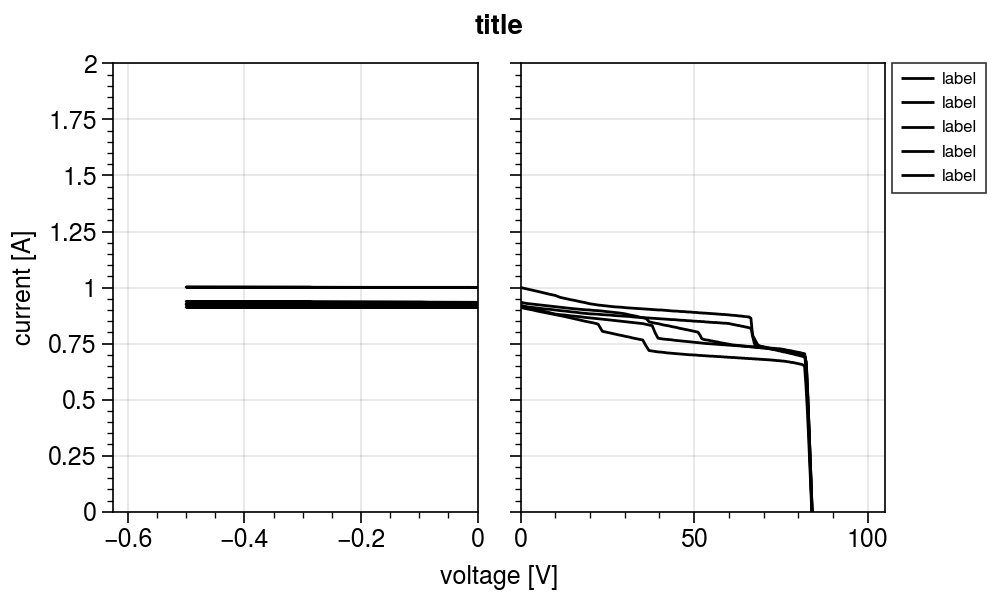

In [105]:

surface = po.get_surfaces()[0]
hoy = 12

i_l = [po.get_dict_instance([surface,string,module])['CURVES'][po.topology]['Imod'][hoy] for module in po.get_modules(surface,string)]
v_l = [po.get_dict_instance([surface,string,module])['CURVES'][po.topology]['Vmod'][hoy] for module in po.get_modules(surface,string)]

ipv_plots.plot_curves(i_l,
                      v_l,
                      po.cell.parameters_dict,
                      y_max=2)

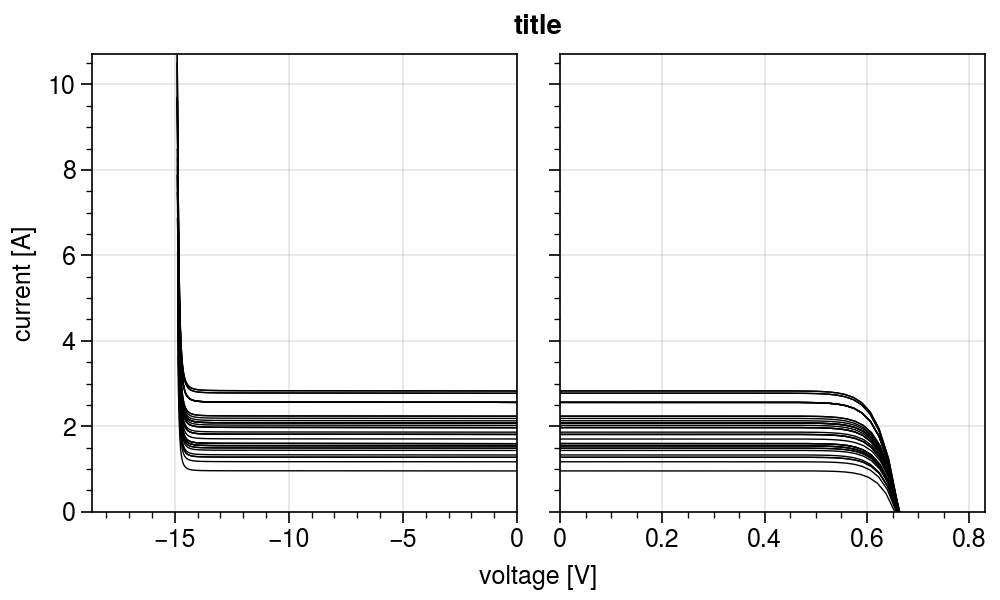

In [849]:
diode_number = 1
ipv_plots.plot_curves(sub_diode_curves_l[diode_number][0,:,:].tolist(),
                      sub_diode_curves_l[diode_number][1,:,:].tolist(),
                      po.cell.parameters_dict,
                      labels=None,
                      linewidth=0.5)

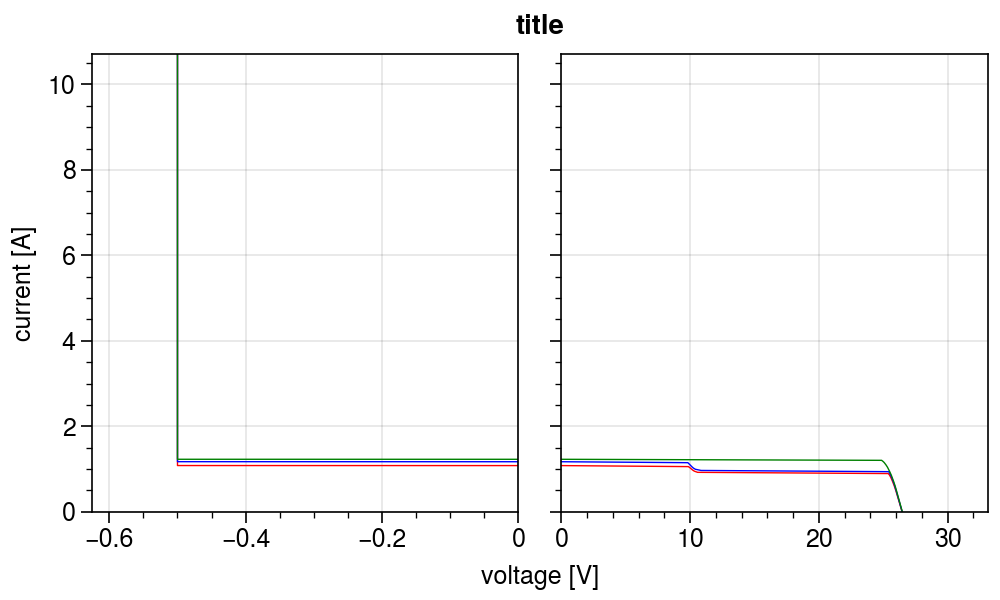

In [850]:
ipv_plots.plot_curves(diode_i,
                      diode_v,
                      po.cell.parameters_dict,
                      labels=None,
                      linewidth=0.5,
                      colors=['red','blue','green'])

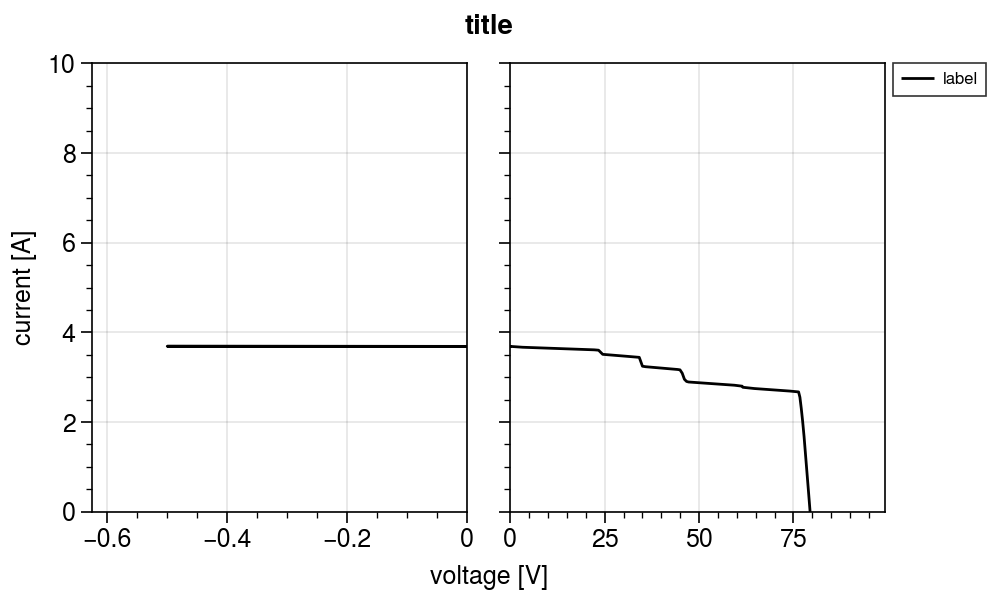

In [866]:
ipv_plots.plot_curves(Imod,
                      Vmod,
                      po.cell.parameters_dict,
                      y_max=10)

# Create Dummy Profiles

In [415]:
def create_sun_mask(file_path):
    sun = pd.read_csv(file_path,names=['HOY']) 
    if len(sun[sun['HOY']==range(1416, 1440)])>0:
        print('Leap days detected')
        
    sun_hours = np.floor(sun).astype(int)
    empty = pd.DataFrame(data={'HOY':list(range(0,8760))})
    def eval_sun_up(HOY,sun_up_list):
        if HOY in sun_up_list:
            return True
        else:
            return False

    sun_up = empty.apply(lambda x: eval_sun_up(x['HOY'],sun_hours['HOY'].tolist()),axis=1)
    sun_up = pd.DataFrame(sun_up).reset_index().rename(columns={"index":"HOY",0:"Sunny"})
    return sun_up, sun_hours


path = "total"
irrad_df_list_total = []
for m in [1,2,3,4,5,6,7,8,9,10,11,12]:
    month = str(m).zfill(2)
    sun_path = f"/Users/jmccarty/Data/220726_vegetation_paper/JuliusBar_2679_1249/hb_model/simulation_repo/cell_Wall2/month_{month}/no_trees/results/simulations/irradiance/annual_irradiance/results/{path}/sun-up-hours.txt"
    ill_path = f"/Users/jmccarty/Data/220726_vegetation_paper/JuliusBar_2679_1249/hb_model/simulation_repo/cell_Wall2/month_{month}/no_trees/results/simulations/irradiance/annual_irradiance/results/{path}/grid_cells_2679_1249_Wall2.ill"
    ill = pd.read_csv(ill_path, delimiter=' ', header=None).iloc[:, 1:].T.reset_index(drop=True)
    sun_up, sun_hours = create_sun_mask(sun_path)
    sun_ill = pd.concat([sun_hours,ill],axis=1)
    irrad_df = pd.merge(sun_up,sun_ill,how="left",on="HOY").fillna(0)
    del irrad_df['Sunny']
    del irrad_df['HOY']
    irrad_df_list_total.append(irrad_df)
    
irrad_df_total = sum(irrad_df_list_total)


path = "direct"
irrad_df_list_direct = []
for m in [1,2,3,4,5,6,7,8,9,10,11,12]:
    month = str(m).zfill(2)
    sun_path = f"/Users/jmccarty/Data/220726_vegetation_paper/JuliusBar_2679_1249/hb_model/simulation_repo/cell_Wall2/month_{month}/no_trees/results/simulations/irradiance/annual_irradiance/results/{path}/sun-up-hours.txt"
    ill_path = f"/Users/jmccarty/Data/220726_vegetation_paper/JuliusBar_2679_1249/hb_model/simulation_repo/cell_Wall2/month_{month}/no_trees/results/simulations/irradiance/annual_irradiance/results/{path}/grid_cells_2679_1249_Wall2.ill"
    ill = pd.read_csv(ill_path, delimiter=' ', header=None).iloc[:, 1:].T.reset_index(drop=True)
    sun_up, sun_hours = create_sun_mask(sun_path)
    sun_ill = pd.concat([sun_hours,ill],axis=1)
    irrad_df = pd.merge(sun_up,sun_ill,how="left",on="HOY").fillna(0)
    del irrad_df['Sunny']
    del irrad_df['HOY']
    irrad_df_list_direct.append(irrad_df)
    
irrad_df_direct = sum(irrad_df_list_direct)
irrad_df_diffuse = irrad_df_total-irrad_df_direct

In [418]:
for stream in ['direct','diffuse']:

    if stream=='direct':
        irrad_df = irrad_df_direct
    elif stream=='diffuse':
        irrad_df = irrad_df_diffuse
        
    sample_A = list(irrad_df.sum(axis=0).sort_values(ascending=False)[0:25].index)
    sample_B = list(irrad_df.sum(axis=0).sort_values(ascending=True)[10890:10890+25].index)
    sample_C = list(irrad_df.sum(axis=0).sort_values(ascending=True)[7260:7260+25].index)
    sample_D = list(irrad_df.sum(axis=0).sort_values(ascending=True)[3630:3630+25].index)
    samples = utils.flatten_list([sample_A,sample_B,sample_C,sample_D])

    sample_df = pd.DataFrame(irrad_df[samples].to_numpy())
    sample_df.to_csv(f"/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/ipv_workbench/sample/irradiance_profiles_{stream}.csv",index=False)

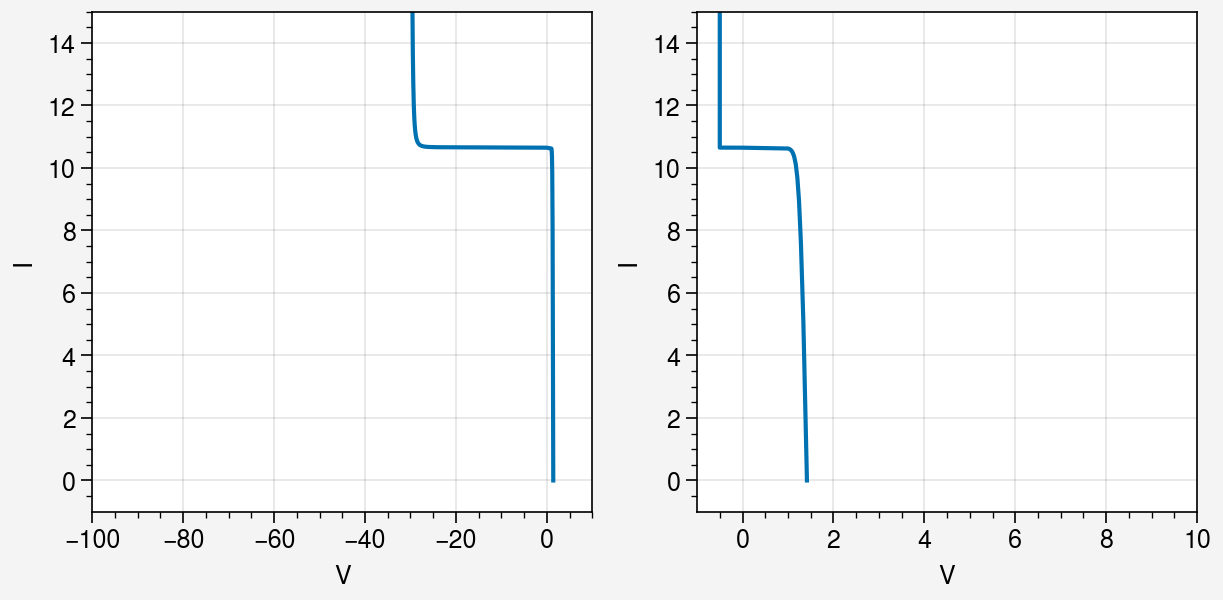

In [274]:
curves_isc = utils.calc_short_circuit(iv_curves)
max_currents = utils.calc_current_max(iv_curves,my_cell)


fig, axe = pplt.subplots(ncols=2,sharey=False,sharex=False)
series = circuits.calc_series(iv_curves,curves_isc,max_currents, bypass=False)
s = pd.DataFrame({'I':series[0],'V':series[1]})
s.sort_values(by='V')
axe[0].line(x=s['V'],y=s['I'])
axe[0].format(xlim=[-100,10],
              ylim=[-1,15])

series = circuits.calc_series(iv_curves,curves_isc,max_currents, bypass=True)
s = pd.DataFrame({'I':series[0],'V':series[1]})
s.sort_values(by='V')
axe[1].line(x=s['V'],y=s['I'])
axe[1].format(xlim=[-1,10],
              ylim=[-1,15])



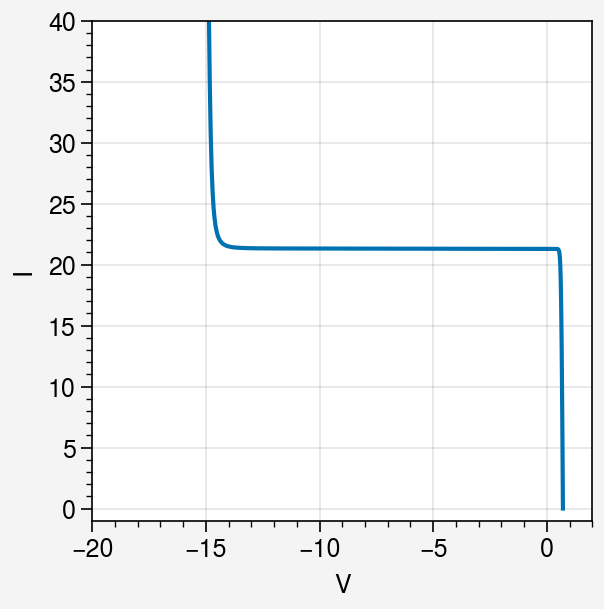

In [276]:
fig, axe = pplt.subplots(ncols=1,sharey=False,sharex=False)
parallel = circuits.calc_parallel(iv_curves)
s = pd.DataFrame({'I':parallel[0],'V':parallel[1]})
s = s.sort_values(by='V')
axe[0].line(x=s['V'],y=s['I'])
axe[0].format(xlim=[-20,2],
              ylim=[-1,40])


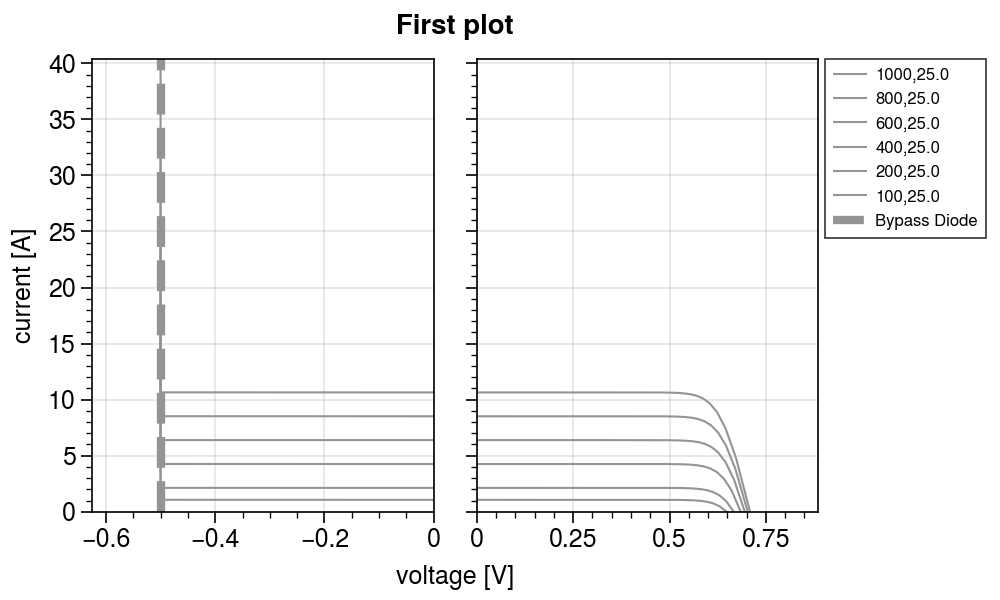

In [97]:
my_cell.cell_plot_iv([1000,800,600,400,200,100],25,'First plot',mpp=False)

In [47]:
my_module_null = devices.Module()
my_module_a = devices.Module()
my_module_b = devices.Module()

In [48]:
my_module_a.cell = my_cell
my_module_b.cell = my_cell

In [57]:
def open_panelizer_file(file_path):
    with open(file_path,"rb") as fp:
        panelized_object = pickle.load(fp)
    return panelized_object

# Archive

In [147]:
conditions = utils.create_conditions_map()

simulation_results = {}

for n in range(0,len(conditions)):
    irrad = conditions[n][0]
    temp = conditions[n][1]
    key = f"{irrad},{temp}"
    simulation_results[key] = {"i":[],
                               "v":[]}
    results = ipv_sim.simulate_cell_curve(my_cell.parameters_dict,
                            irrad,
                            temp,
                            1000)
    results = np.array(results)
    simulation_results[key]['i'] = list(results[0,:])
    simulation_results[key]['v'] = list(results[1,:])

In [148]:
iv_library_name = "/Users/jmccarty/Data/220723_iv_library/library/test_cell/test_gzip.gz"


json_str = json.dumps(simulation_results) + "\n"               # 2. string (i.e. JSON)
json_bytes = json_str.encode('utf-8')            # 3. bytes (i.e. UTF-8)

with gzip.open(iv_library_name, 'w') as fout:       # 4. fewer bytes (i.e. gzip)
    fout.write(json_bytes)    

In [232]:
iv_library_name = "/Users/jmccarty/Data/220723_iv_library/library/test_cell/test_gzip.gz"

with gzip.open(iv_library_name, 'r') as fin:        # 4. gzip
    json_bytes = fin.read()                      # 3. bytes (i.e. UTF-8)

json_str = json_bytes.decode('utf-8')            # 2. string (i.e. JSON)
data = json.loads(json_str)                      # 1. data

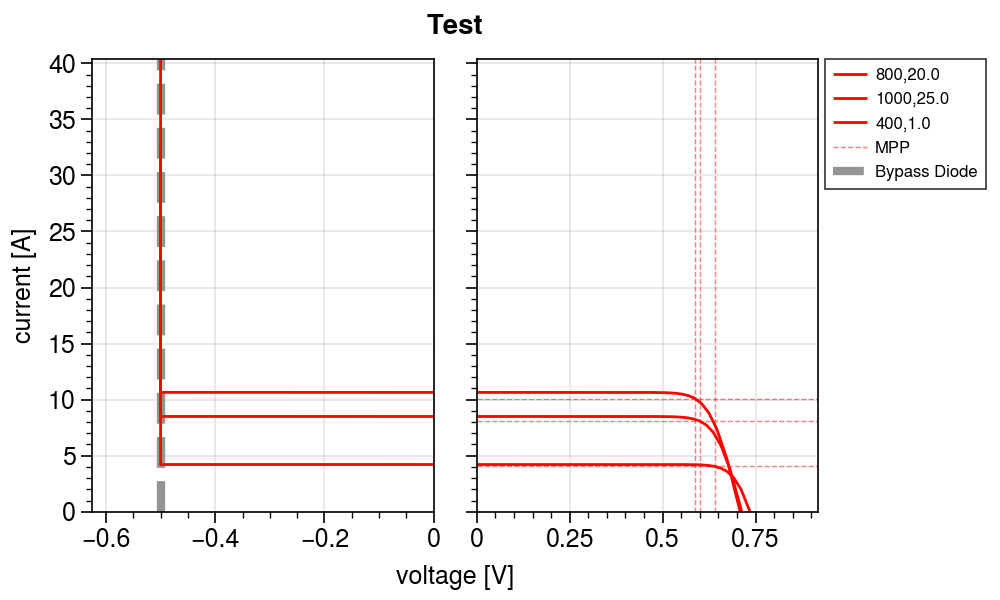

In [21]:

data = my_cell.iv_library
conditions = my_cell.iv_library_conditions
i_arrs = []
v_arrs = []
labels = []
for irrad, temp in [(800,20.01),(1000,25.0),(400,1.0)]:
    iv_key = utils.find_matching_key(data.keys(),conditions,irrad,temp)
    labels.append(iv_key)
    i_arrs.append(data[iv_key]['i'])
    v_arrs.append(data[iv_key]['v'])


# plot_curves(i_arrs, v_arrs, labels, 'no title', [1,2,3], ['k','blue','red'], ['solid','solid','solid'], fs=(5, 3),bypass=-5)
ipv_plots.plot_curves(i_arrs, v_arrs,
                    my_cell.parameters_dict,
                    labels=labels,
                    title='Test',
                    linewidth=1,
                    colors='red',
                    linestyle='solid',
                    fs=(5,3), 
                    bypass=True, 
                    mpp=True,
                    # y_max=12,
                    reverse=True,
                    # save='sample_iv_curve_cell_no_reverse.pdf'
                    )